<a href="https://colab.research.google.com/github/darelover/Music-Genre-Classification/blob/master/Music_Genre_Classification_using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
cd ../gdrive/My Drive/MGC

/gdrive/My Drive/MGC


In [3]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

import keras

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Dataset used :-

This notebook uses [GTZAN Genre Collection](http://marsyas.info/downloads/datasets.html) for training the classifier. The dataset consists of 1000 audio tracks each 30 seconds long. It contains 10 genres(blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock), each represented by 100 tracks. The tracks are all 22050Hz Mono 16-bit audio files in .wav format.

## Feature Extraction 

Using librosa library we extract following features from the audio file:-


* Chromagram
* Root-mean-square (RMS) energy for each frame
* Spectral Centroid
* Spectral Bandwidth
* Spectral Roll-off.
* Zero Crossing Rate
* Mel-frequency cepstral coefficients (MFCCs)

All of these features are written into "data.csv" file

In [0]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += " mfcc{}".format(i)
header += " label"
header = header.split()

In [0]:
if not os.path.exists('data.csv'):

  file = open('data.csv', 'w')
  with file:
      writer = csv.writer(file)
      writer.writerow(header)
  genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
  for g in genres:
      for filename in os.listdir("./genres/{}".format(g)):
          songname = "./genres/{}/{}".format(g,filename)
          y, sr = librosa.load(songname, mono=True, duration=30)

          chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
          rmse        = librosa.feature.rmse(y=y)
          spec_cent   = librosa.feature.spectral_centroid(y=y, sr=sr)
          spec_bw     = librosa.feature.spectral_bandwidth(y=y, sr=sr)
          rolloff     = librosa.feature.spectral_rolloff(y=y, sr=sr)
          zcr         = librosa.feature.zero_crossing_rate(y)
          mfcc        = librosa.feature.mfcc(y=y, sr=sr)

          to_append = "{} {} {} {} {} {} {}".format(filename,np.mean(chroma_stft),np.mean(rmse),np.mean(spec_cent),np.mean(spec_bw),np.mean(rolloff),np.mean(zcr))
          for e in mfcc:
              to_append += " {}".format(np.mean(e))
          to_append += " {}".format(g)
          file = open('data.csv', 'a')
          with file:
              writer = csv.writer(file)
              writer.writerow(to_append.split())

In [6]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00043.au,0.399025,0.127311,2155.654923,2372.403604,5012.019693,0.087165,-109.165355,100.621500,-8.614721,...,6.585774,-8.642621,4.912259,-15.442804,1.538750,-6.732474,1.417774,-3.961750,3.287460,blues
1,blues.00012.au,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,-15.438986,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
2,blues.00026.au,0.278484,0.076970,1198.607665,1573.308974,2478.376680,0.051988,-284.819504,108.785628,9.131956,...,-3.303735,1.601561,2.660517,3.323455,3.258920,-4.551106,0.493845,5.937066,3.231544,blues
3,blues.00077.au,0.408876,0.243217,2206.771246,2191.473506,4657.388504,0.111526,-29.010990,104.532914,-30.974207,...,10.786454,-10.558812,6.877709,-10.294858,6.967845,-10.256100,0.705014,-6.000722,1.348955,blues
4,blues.00084.au,0.396258,0.235238,2061.150735,2085.159448,4221.149475,0.113397,-38.965941,112.039843,-31.817035,...,13.327049,-10.921602,9.795615,-5.031277,7.200982,-6.754969,2.663612,-4.380430,0.414055,blues


In [7]:
data.shape

(1000, 28)

In [0]:
data = data.drop(['filename'], axis=1)

In [9]:
data

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.399025,0.127311,2155.654923,2372.403604,5012.019693,0.087165,-109.165355,100.621500,-8.614721,47.358475,...,6.585774,-8.642621,4.912259,-15.442804,1.538750,-6.732474,1.417774,-3.961750,3.287460,blues
1,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,-15.438986,60.986727,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
2,0.278484,0.076970,1198.607665,1573.308974,2478.376680,0.051988,-284.819504,108.785628,9.131956,51.259030,...,-3.303735,1.601561,2.660517,3.323455,3.258920,-4.551106,0.493845,5.937066,3.231544,blues
3,0.408876,0.243217,2206.771246,2191.473506,4657.388504,0.111526,-29.010990,104.532914,-30.974207,38.156392,...,10.786454,-10.558812,6.877709,-10.294858,6.967845,-10.256100,0.705014,-6.000722,1.348955,blues
4,0.396258,0.235238,2061.150735,2085.159448,4221.149475,0.113397,-38.965941,112.039843,-31.817035,38.240835,...,13.327049,-10.921602,9.795615,-5.031277,7.200982,-6.754969,2.663612,-4.380430,0.414055,blues
5,0.376687,0.141018,1239.337228,1659.466470,2517.618110,0.050908,-206.278431,126.627468,10.585205,43.223168,...,3.659409,-1.448481,-1.695150,-7.157464,1.171114,-6.221975,0.600703,-1.605095,-0.528774,blues
6,0.337922,0.129096,2258.538419,2176.031189,4755.429578,0.112765,-95.424423,101.368652,-20.682497,48.655476,...,7.723721,-19.224149,2.856372,-9.809445,6.911756,-11.303164,8.940704,-2.959639,-0.975428,blues
7,0.233230,0.197818,1247.244815,1908.052722,2620.592487,0.036904,-200.220732,116.345181,18.060785,25.288819,...,-12.015285,-17.009242,-8.115376,-11.959014,-12.617977,-14.187781,-8.204476,-15.024769,-10.322150,blues
8,0.363603,0.175573,1552.481958,1747.165985,3040.514948,0.076301,-90.754394,140.459907,-29.109965,31.689014,...,5.789265,-8.905224,-1.083720,-9.218359,2.455805,-7.726901,-1.815724,-3.433434,-2.226821,blues
9,0.412501,0.168358,2171.221742,1954.383785,4237.132712,0.132802,-76.717959,105.753530,-43.181755,60.945850,...,12.726959,-9.366809,1.350859,-3.609972,6.997609,-4.053008,-0.271427,-3.696092,-0.504041,blues


## Preprocessing 

In [0]:
from sklearn.preprocessing import LabelEncoder

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
Y = encoder.fit_transform(genre_list)

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
# scaler = MinMaxScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [13]:
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(800, 26)
(200, 26)
(800,)
(200,)


In [14]:
print X_train[10]
print Y_train[10]

[ 1.01917182  0.52815537  0.66474826  0.18000972  0.5049127   1.00801563
  0.3095328  -0.99262198 -0.31524209  1.20685001 -0.57347174  1.04877641
 -0.72815567  1.00821664 -0.6860442   0.97025286 -0.73131062  1.4264014
 -1.24986182  1.12289131 -1.93920306 -0.30371314 -1.77674218  0.85585748
 -0.09275548  1.75649946]
4


## Classification with Keras

In [42]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.regularizers import l1, l2

model = Sequential()

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               6912      
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_12 (Batc (None, 64)                256       
__________

In [0]:
optim = keras.optimizers.sgd(lr=0.005)
# optim = keras.optimizers.rmsprop()
# optim = keras.optimizers.adam()
model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

hist = model.fit(X_train,
                 Y_train,
                 epochs=15,
                 batch_size=16,
                 validation_data=(X_test,Y_test),
#                  callbacks = [early_stop],
                 shuffle=True
                )

Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 1s 2ms/step - loss: 5.4520 - acc: 0.2225 - val_loss: 4.6735 - val_acc: 0.4400
Epoch 2/15
800/800 [==============================] - 0s 581us/step - loss: 4.9181 - acc: 0.3488 - val_loss: 4.4568 - val_acc: 0.4950
Epoch 3/15
800/800 [==============================] - 0s 605us/step - loss: 4.6063 - acc: 0.4412 - val_loss: 4.3368 - val_acc: 0.5150
Epoch 4/15
800/800 [==============================] - 0s 597us/step - loss: 4.4781 - acc: 0.4725 - val_loss: 4.2185 - val_acc: 0.5450
Epoch 5/15
800/800 [==============================] - 0s 588us/step - loss: 4.3346 - acc: 0.5312 - val_loss: 4.1164 - val_acc: 0.6000
Epoch 6/15
800/800 [==============================] - 0s 579us/step - loss: 4.2517 - acc: 0.5325 - val_loss: 4.0738 - val_acc: 0.6000
Epoch 7/15
800/800 [==============================] - 0s 603us/step - loss: 4.1906 - acc: 0.5375 - val_loss: 3.9967 - val_acc: 0.6100
Epoch 8/15
800/800

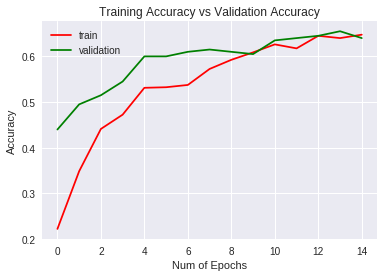

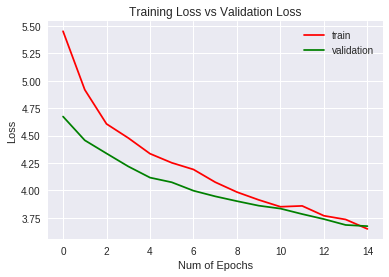

In [45]:
plt.figure(0)
plt.plot(hist.history['acc'],'r')
plt.plot(hist.history['val_acc'],'g')
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'g')
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

In [0]:
predictions = model.predict(X_test)

In [47]:
predictions.shape

(200, 10)

In [48]:
np.argmax(predictions[0])

3

In [49]:
Y_test[0]

3

In [50]:
df = pd.DataFrame()
df["predictions"] = np.argmax(predictions,axis=1)
df["actual labels"] = Y_test

df

,predictions,actual labels
0,3,3
1,4,6
2,5,5
3,5,5
4,1,1
5,2,2
6,1,1
7,7,7
8,3,2
9,1,1
